#### Setup

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

import pandas as pd

from sentinelhub import SHConfig

config = SHConfig()

#### Loading the Data

In [2]:
absdorf_bbox_coords = [15.969363,48.405107,15.972641,48.406845]
absdorf_bbox_coords = [
  15.968838,
  48.404456,
  15.975341,
  48.408053
]
au_am_leitha_1_bbox_coords = [16.529000,47.930621,16.533941,47.932141]
resolution = 60
absdorf_bbox = BBox(bbox=absdorf_bbox_coords, crs=CRS.WGS84)
absdorf_bbox_size = bbox_to_dimensions(absdorf_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {absdorf_bbox_size} pixels")

Image shape at 60 m resolution: (8, 7) pixels


In [3]:
with open("Datasets/bestand_31_10_22.csv") as file:
        bestand = pd.read_csv(file)

In [4]:
# Add the coords to the df (with weird string workaround since lists dont go into cells with loc)
bestand.loc[bestand['SITE'] == "Abs", 'BoundingBox'] =  f"{absdorf_bbox_coords}"
bestand.loc[bestand['SITE'] == "Au1", 'BoundingBox'] =  f"{au_am_leitha_1_bbox_coords}"

In [5]:
# update the file
bestand.to_csv("Datasets/bestand_31_10_22.csv")

#### Retrieving the satellite data

In [6]:
from typing import Any, Optional, Tuple

def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: Optional[Tuple[float, float]] = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

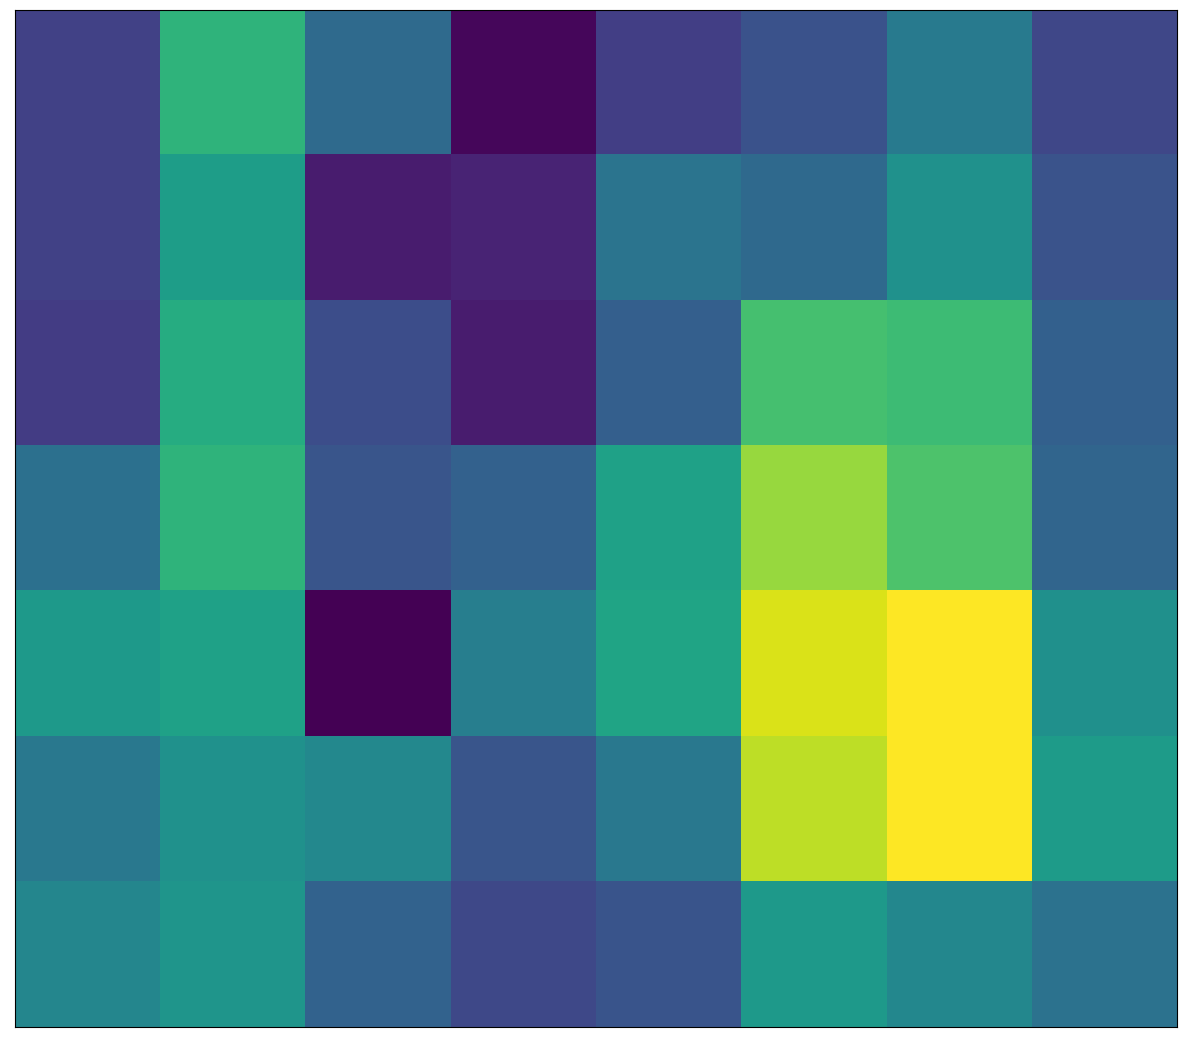

In [7]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

request_all_bands = SentinelHubRequest(
    data_folder="SatelliteImages",
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-01", "2020-06-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=absdorf_bbox,
    size=absdorf_bbox_size,
    config=config,
)

#all_bands_response = request_all_bands.get_data(save_data=True)

# Image showing the SWIR band B12
# Factor 1/1e4 due to the DN band values in the range 0-10000
# Factor 3.5 to increase the brightness
#plot_image(all_bands_response[0][:, :, 12], factor=3.5 / 1e4, vmax=1)

In [9]:
# read data from disk
all_bands_img_from_disk = request_all_bands.get_data()

#### Plotting the Band Histograms

In [10]:
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [18]:
# move the bands to a nice np-array
stacked_bands = np.stack(all_bands_img_from_disk)
stacked_bands = np.moveaxis(stacked_bands, 3, 0).squeeze()
stacked_bands.shape

(13, 7, 8)

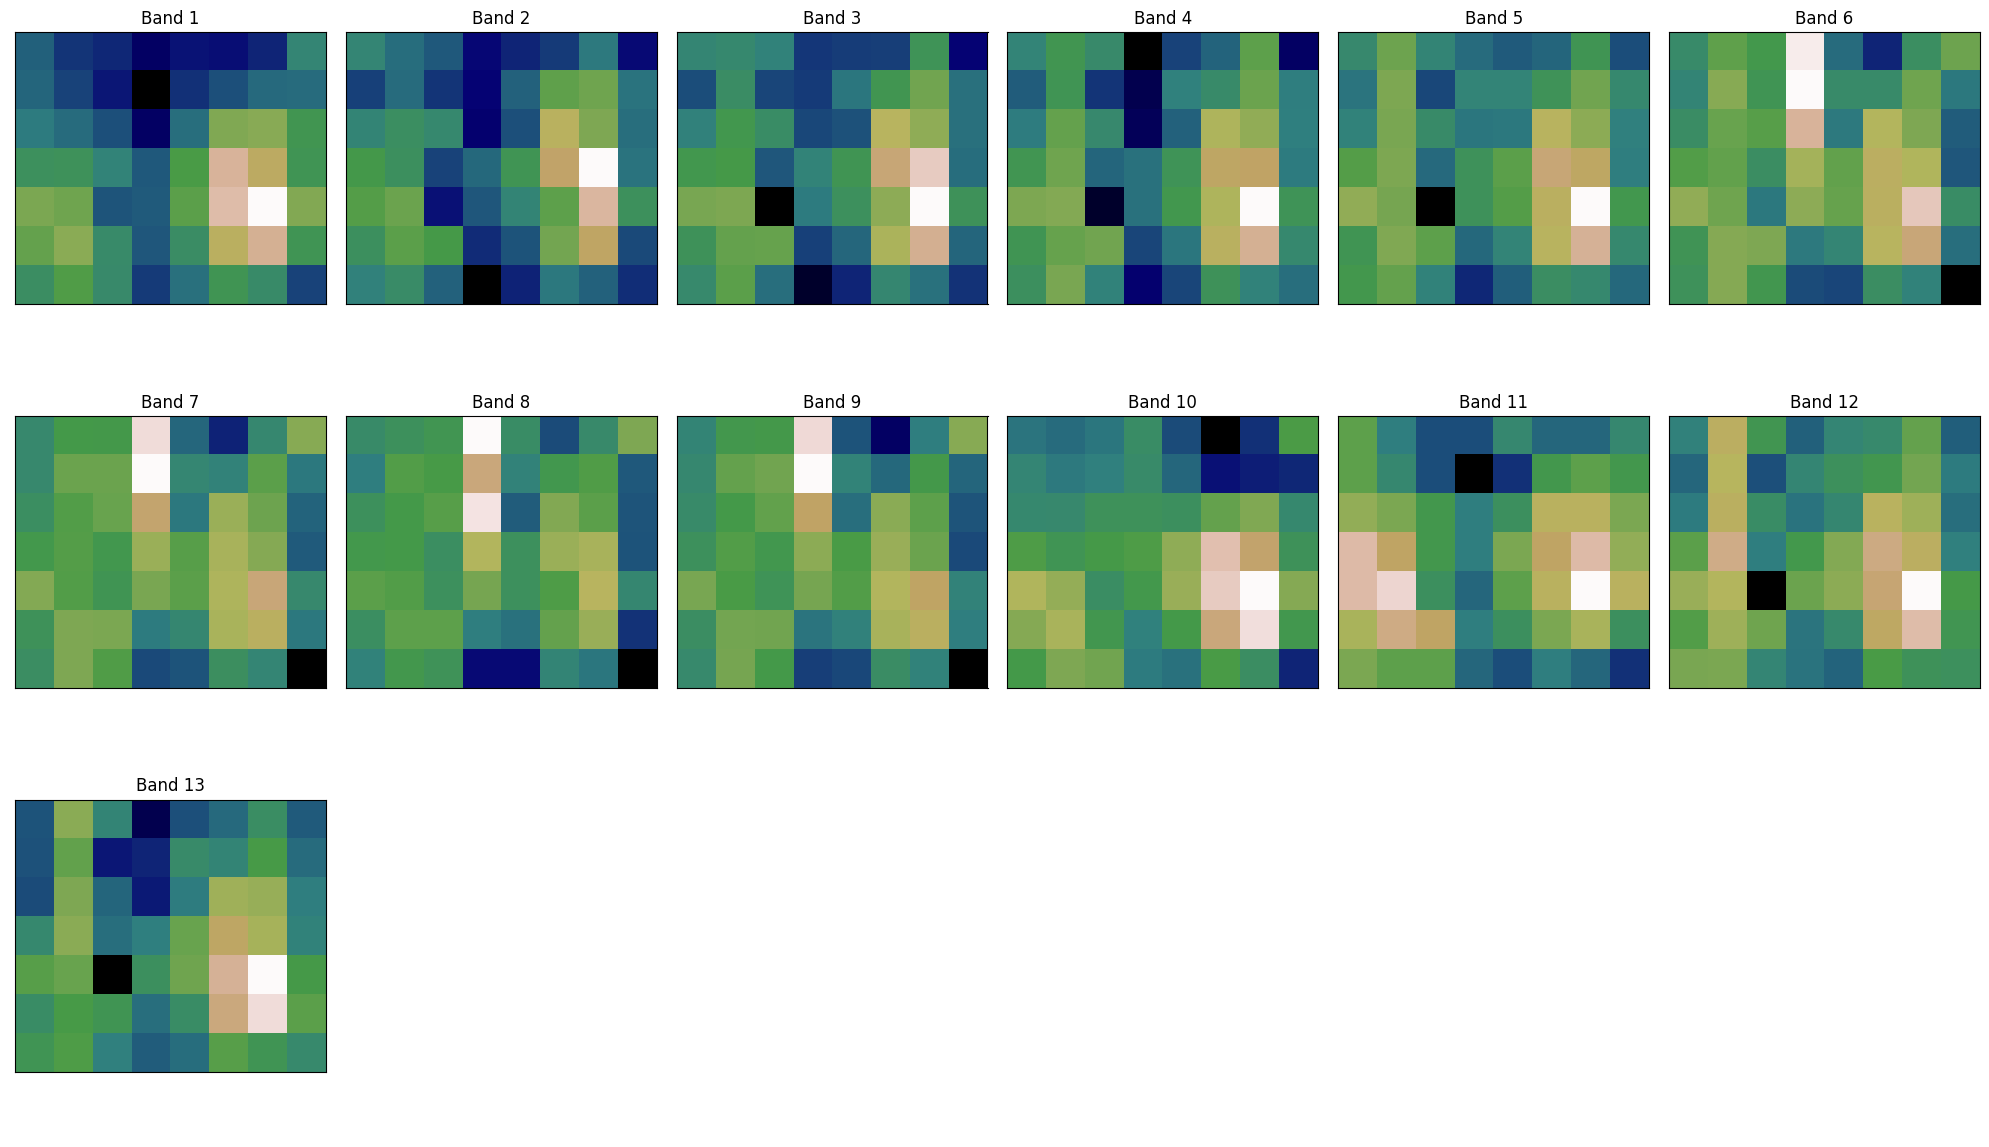

In [20]:
# Plot all bands
ep.plot_bands(stacked_bands, 
              cmap = 'gist_earth', 
              figsize = (20, 12), 
              cols = 6, 
              cbar = False)
plt.show()

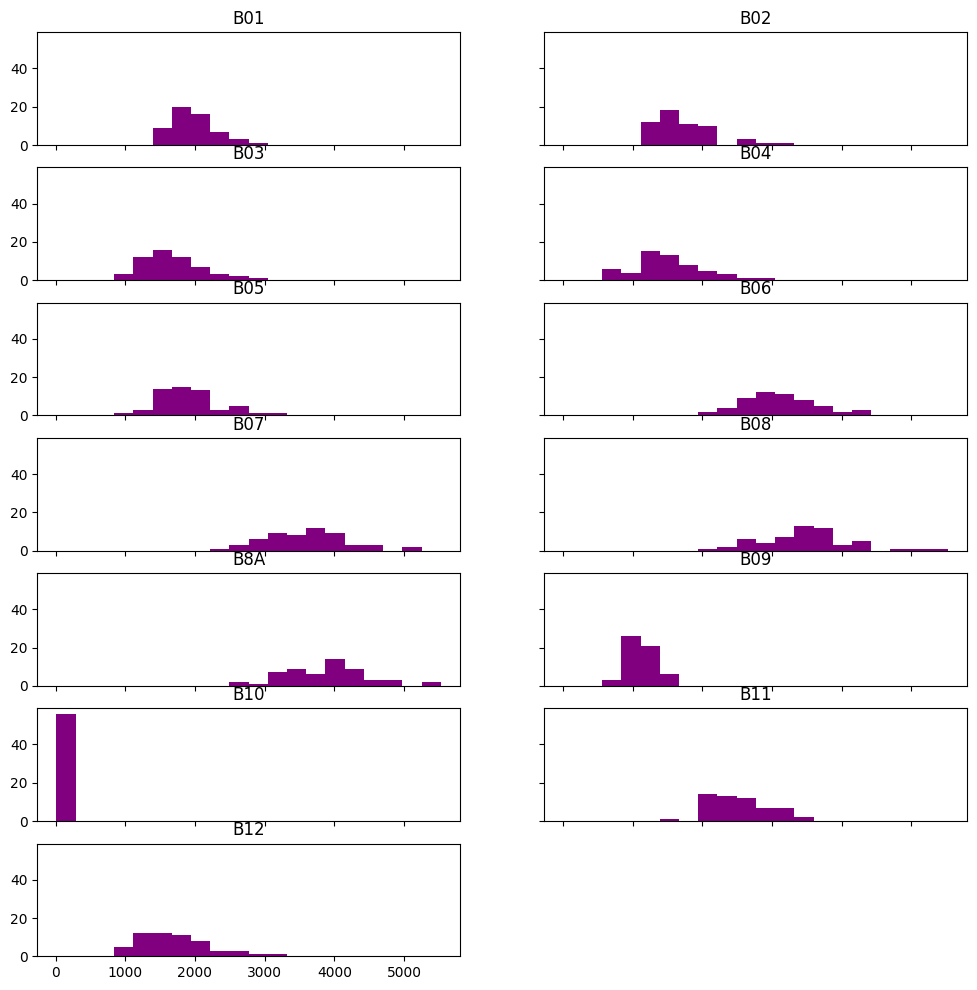

In [26]:
# Create the list of titles for each band. The titles and colors listed
# in this example reflect the order and wavelengths of the Landsat 8 bands
titles = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]

# and a histogram of the spectrums
ep.hist(stacked_bands, title=titles)
plt.show()

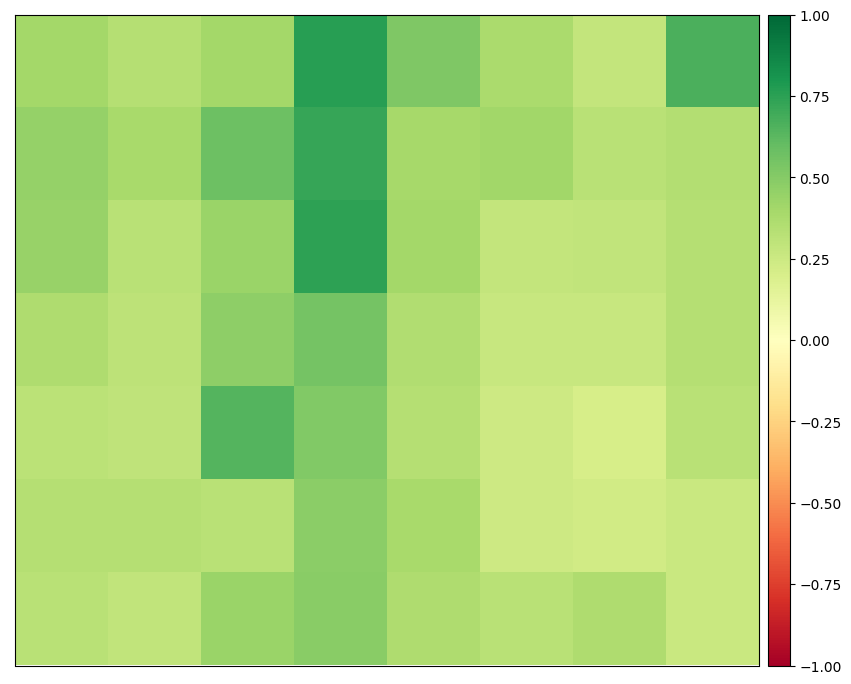

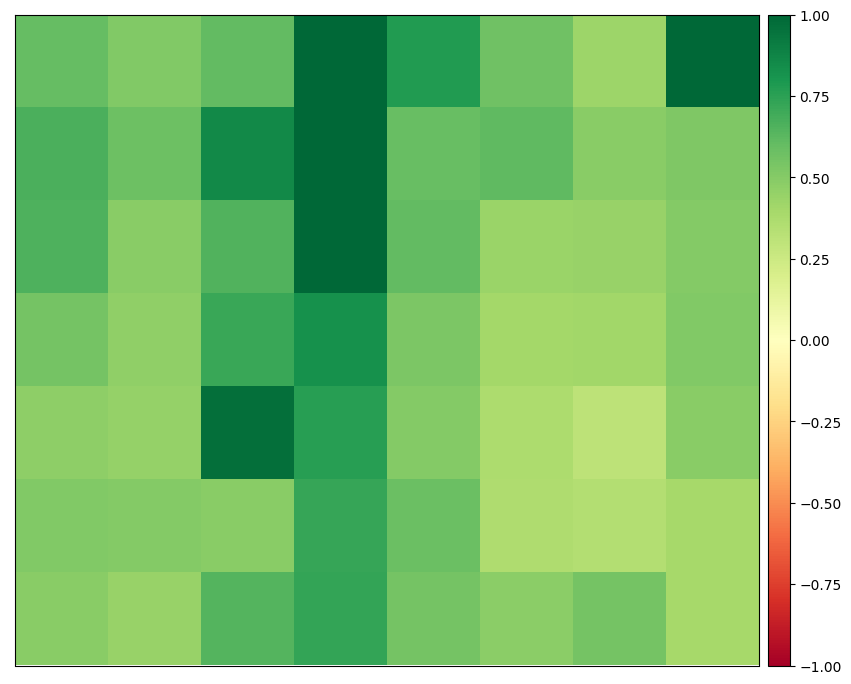

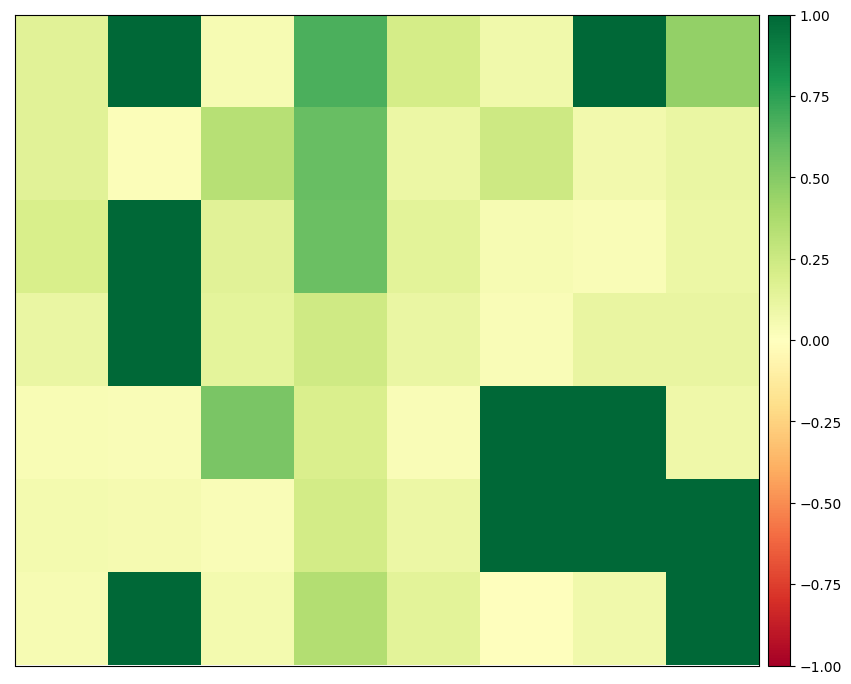

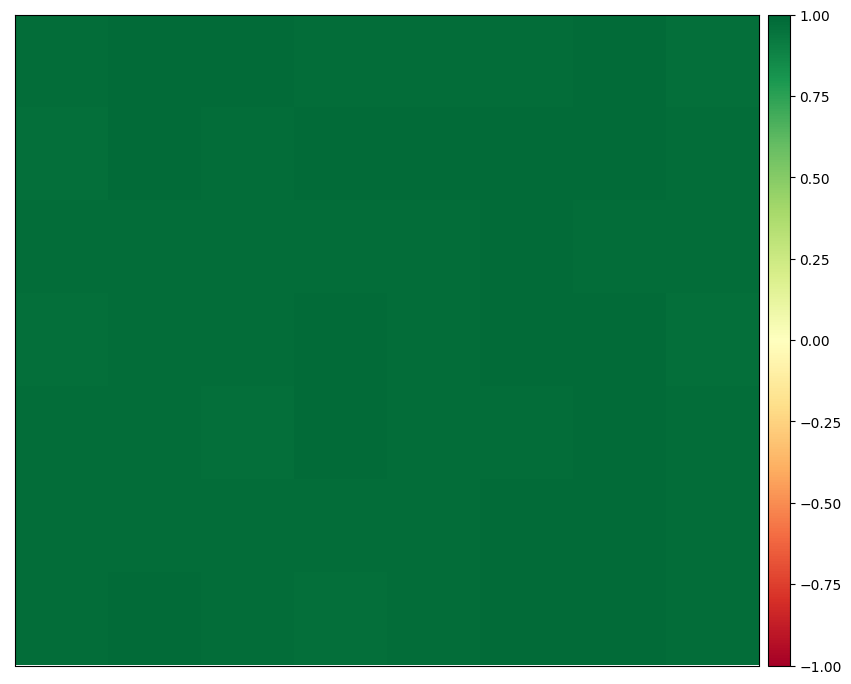

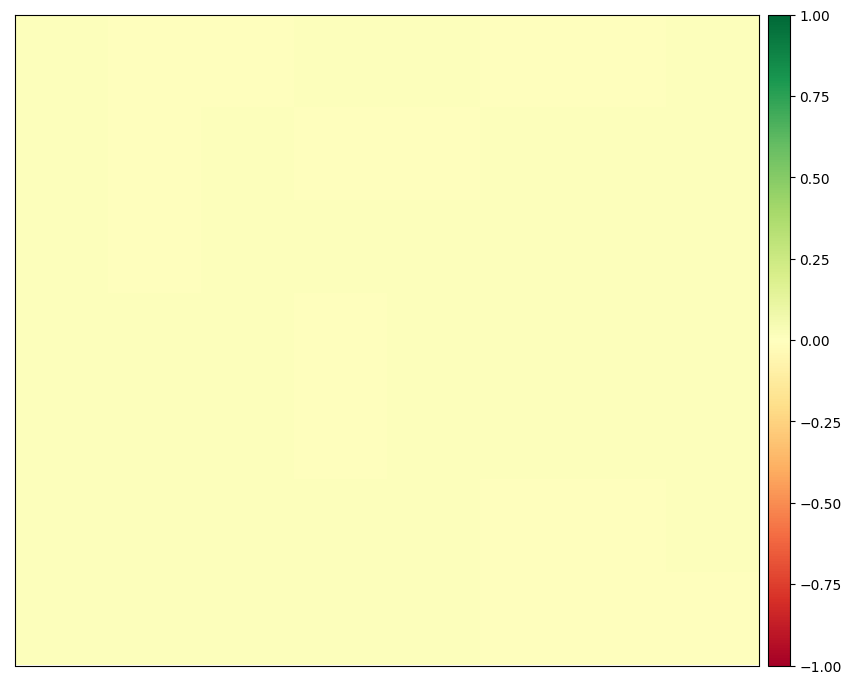

In [27]:
ndvi = es.normalized_diff(stacked_bands[7], stacked_bands[3])

L = 0.5
savi = ((stacked_bands[7] - stacked_bands[3]) / (stacked_bands[7] + stacked_bands[3] + L)) * (1 + L)

vari = (stacked_bands[2] - stacked_bands[3])/ (stacked_bands[2] + stacked_bands[3] - stacked_bands[1])

mndwi = es.normalized_diff(stacked_bands[2], stacked_bands[10])

cmr = np.divide(stacked_bands[10], stacked_bands[11])

indices = [ndvi,savi,vari,mndwi,cmr]

for index in indices:
    ep.plot_bands(index, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

In [31]:
# Build the SCMaP bare soil covering mechanism as per https://www.sciencedirect.com/science/article/pii/S003442571730514X
# check whether the reflectances are within given thresholds -> if so, they are probably bare soil

pv = ((stacked_bands[7]-stacked_bands[3])/(stacked_bands[7]+stacked_bands[3]))+ ((stacked_bands[7]-stacked_bands[1])/(stacked_bands[7]+stacked_bands[1]))

pv_max = max(pv.flatten())
pv_min = min(pv.flatten())
# 1. Create DF with a large number of satellite samples per area
# 2. Compute the pv index for each sample
# 3. Generate pv_max, pv_min for each pixel -> this is on a per-pixel scale whether it is bare soil
# 4. Mask areas based on whether the pv_ value is greater/smaller than the threshold h_
# h_max is used to find fields
h_max = 1.7
h_min = 0.7
# 5. take intersection of both masks
#soil_mask = intersection(soil_mask_h_max, soil_mask_h_min)

#### Downloading a series of images from the same field

In [34]:
# downloading timeseries

start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2019, 12, 31)
n_chunks = 13
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

# modify to accept timeslot
def request_all_bands_timed(time_interval):
    return SentinelHubRequest(
        data_folder="SatelliteImages",
        evalscript=evalscript_all_bands,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=absdorf_bbox,
        size=absdorf_bbox_size,
        config=config,
    )

#all_bands_response = request_all_bands.get_data(save_data=True)

# create a list of requests
list_of_requests = [request_all_bands_timed(slot).get_data(save_data=True) for slot in slots]

Monthly time windows:

('2019-01-01', '2019-01-29')
('2019-01-29', '2019-02-26')
('2019-02-26', '2019-03-26')
('2019-03-26', '2019-04-23')
('2019-04-23', '2019-05-21')
('2019-05-21', '2019-06-18')
('2019-06-18', '2019-07-16')
('2019-07-16', '2019-08-13')
('2019-08-13', '2019-09-10')
('2019-09-10', '2019-10-08')
('2019-10-08', '2019-11-05')
('2019-11-05', '2019-12-03')
